In [1]:
import pandas as pd

In [26]:
df = pd.read_csv('seattle-weather.csv', parse_dates=['date'])

In [37]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
date,,,,,
2015-12-27,8.6,4.4,1.7,2.9,rain
2015-12-28,1.5,5.0,1.7,1.3,rain
2015-12-29,0.0,7.2,0.6,2.6,fog
2015-12-30,0.0,5.6,-1.0,3.4,sun
2015-12-31,0.0,5.6,-2.1,3.5,sun


In [28]:
df.set_index('date', inplace=True)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2012-01-01 to 2015-12-31
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1461 non-null   float64
 1   temp_max       1461 non-null   float64
 2   temp_min       1461 non-null   float64
 3   wind           1461 non-null   float64
 4   weather        1461 non-null   object 
dtypes: float64(4), object(1)
memory usage: 68.5+ KB


In [30]:
df.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


Ellipsis

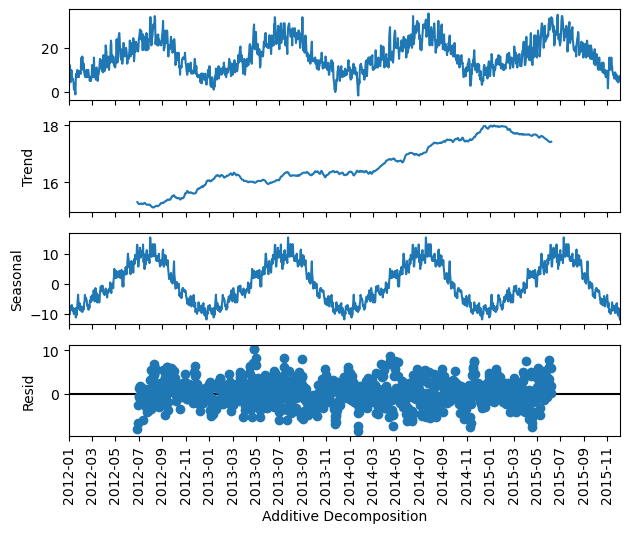

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt



result = seasonal_decompose(df[['temp_max']], model='additive', period=365) # additive seasonal index because temperature can be negative
# Plot the decomposition

fig = result.plot()

# Customize x-ticks to show every 2 months
tick_positions = df[['temp_max']].index[::62]  # Select every 6th month
tick_labels = tick_positions.strftime('%Y-%m')  # Format labels as 'YYYY-MM'
plt.setp(fig.axes, xticks=tick_positions, xticklabels=tick_labels)
plt.xticks(rotation=90)
plt.xlabel('Additive Decomposition')
...

Seasonality is consistent through winters and summers

The trend is going up is an indicator of climate changing or global warming 

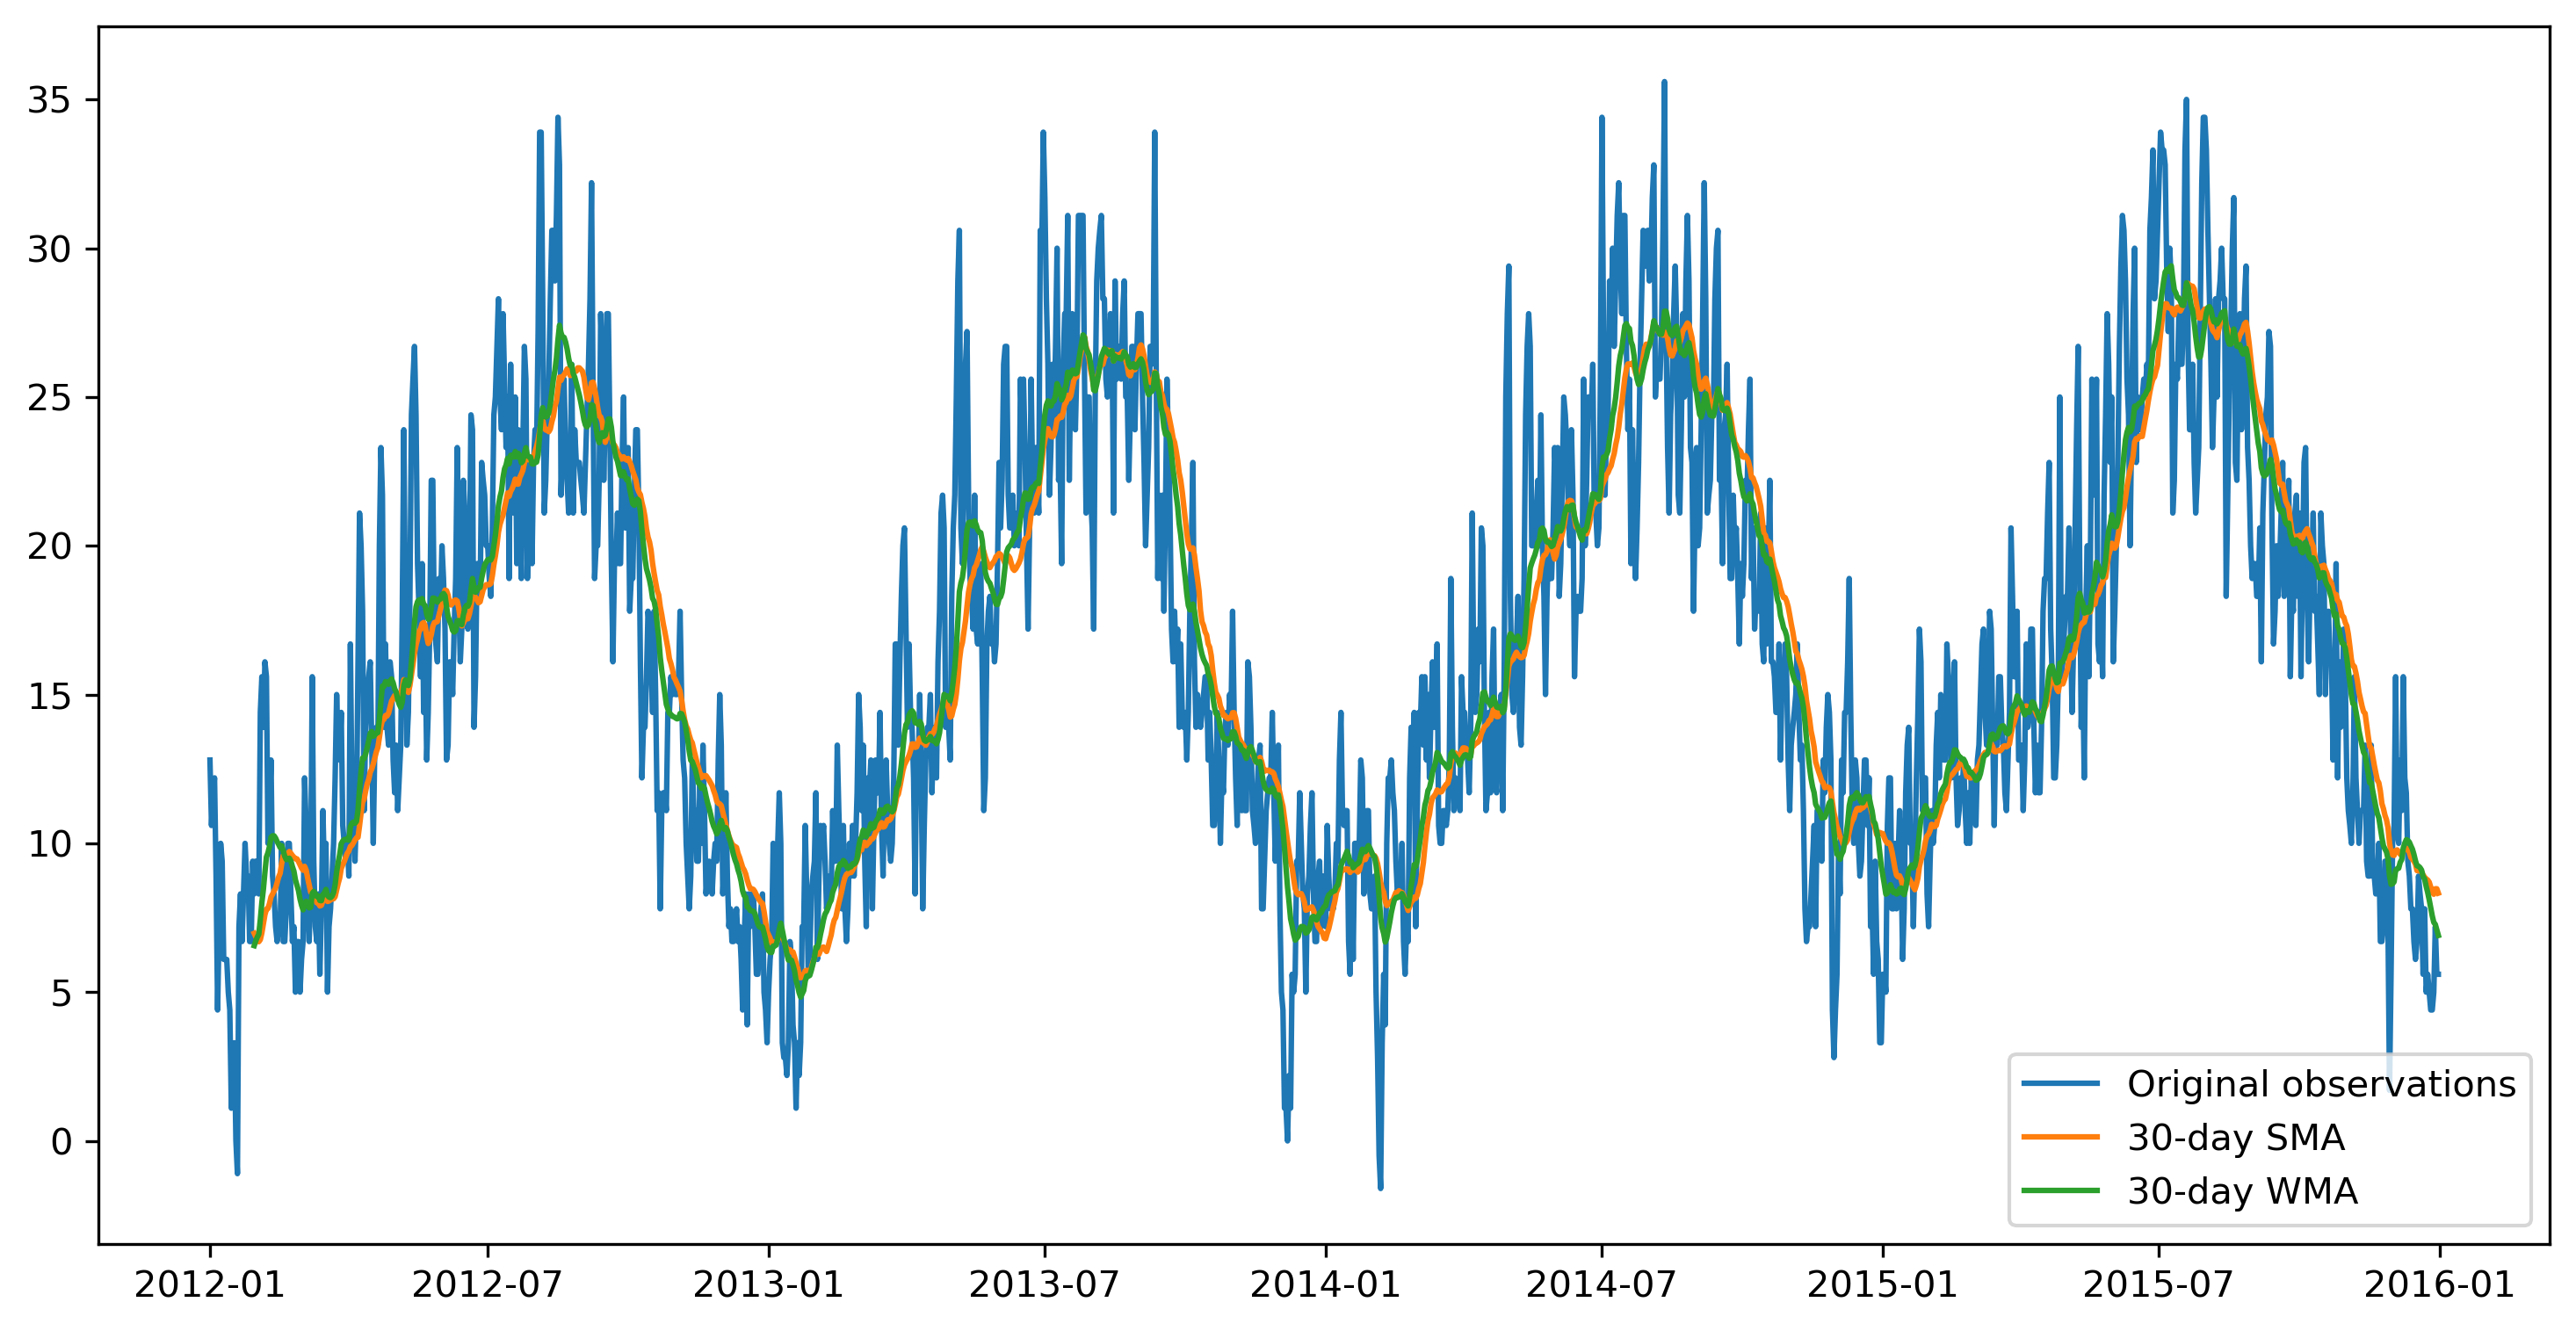

In [52]:
import numpy as np
# Simple Moving Average (SMA)
  # 30-day window
sma = df[["temp_max"]].rolling(window=30).mean()
# Weighted Moving Average (WMA)
weights = np.arange(1, 31)  # Linearly increasing weights
wma = df[["temp_max"]].rolling(window=30).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)

# Plotting sma and wma
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df[["temp_max"]], label='Original observations')
plt.plot(sma, label='30-day SMA')
plt.plot(wma, label='30-day WMA')
plt.legend()

In [78]:
weather_dummies = pd.get_dummies(df['weather'], prefix='weather', dummy_na=True)
df = pd.concat([df.drop('weather', axis = 1), weather_dummies], axis=1)

In [107]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# convert the numpy array back to a pandas DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
# aggregate the data by month to capture seasonality
df_m = df_scaled.resample('ME').mean()

In [108]:
# building SARIMA model with auto_arima
from pmdarima import auto_arima
model = auto_arima(df_m[['temp_max']].iloc[:-12], 
                   exogenous=df_m.drop('temp_max', axis = 1).iloc[:-12],
                   seasonal=True, 
                   m=12, 
                   trace=True, 
                   error_action='ignore', 
                   d=1,                 
                   D=1,
                   alpha = 0.05,
                   maxiter = 50,
                   start_p=2, start_q=2,
                   information_criterion = 'aic',
                   out_of_sample_size = 12,
                   stepwise=True
                   )

# Print the summary of the model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=19.297, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=13.986, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7.705, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=10.654, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=11.351, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=9.410, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=7.726, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=13.370, Time=0.24 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=18.809, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=12.809, Time=0.30 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=12.269, Time=0.13 s

So, auto arima figured that the best model is with q 1, and P 1

Which makes since, best month to predict next month in winter is the same month last year, 

and second best month to do so is the residuals from predicting last month

In [109]:
forecast, conf_int = model.predict(n_periods=12, 
                                    return_conf_int=True,
                                    alpha=0.05) 
future_dates = pd.date_range(start=df_m.index[-12],
                            periods=12,
                            freq='ME')
df_pred = model.predict(n_periods = 12, freq = 'ME')

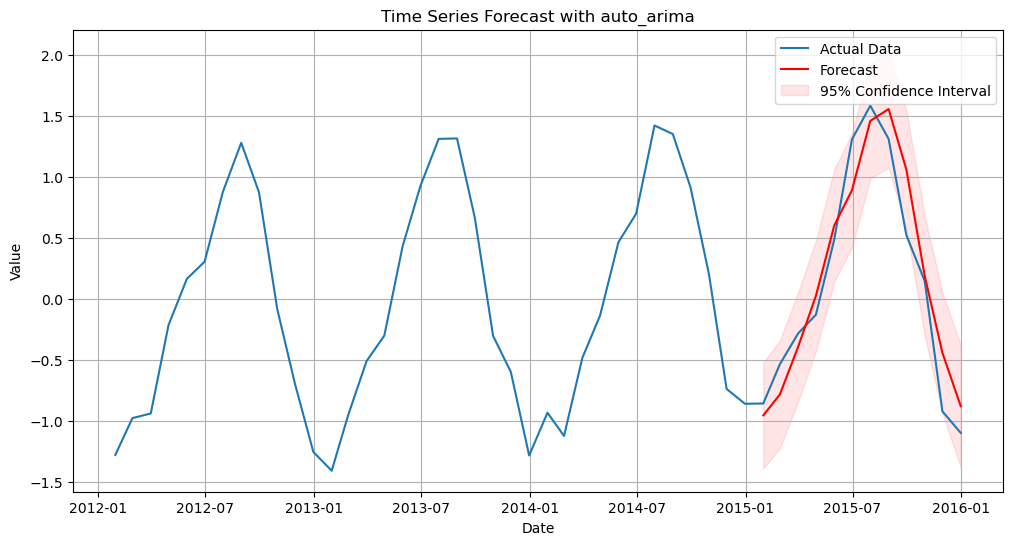

In [110]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_m['temp_max'][:].index, df_m['temp_max'][:], label='Actual Data')
plt.plot(future_dates, forecast, color='red', label='Forecast')
plt.fill_between(future_dates,
                conf_int[:, 0],
                conf_int[:, 1],
                color='red',
                alpha=0.1,
                label='95% Confidence Interval')
plt.title('Time Series Forecast with auto_arima')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
from sklearn.metrics import mean_squared_error

# Calculate the mean squared error
mse = mean_squared_error(df_m['temp_max'][-12:], forecast)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.07820093668791302
